This initial module handles environment setup, data ingestion, identification of categorical features, and the necessary preprocessing steps, primarily Ordinal Encoding, to prepare the feature matrix for modeling.

In [33]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt


#  Load dataset
def load_adult():
    df = fetch_openml('adult', version=2, as_frame=True)['frame']
    target_col = 'class'
    X = df.drop(columns=[target_col]).copy()
    y_raw = df[target_col].astype(str).str.strip()
    y = y_raw.replace({'<=50K.': '<=50K', '<=50K': '<=50K', '>50K.': '>50K', '>50K': '>50K'})
    y = (y == '>50K').astype(int)
    return X, y


# Find categorical columns helper
def get_categorical_columns(X):
    return [c for c in X.columns if X[c].dtype == 'object' or X[c].dtype.name == 'category']


# Preprocess categorical: replace missing and ordinal-encode
def preprocess_categorical(X, selected_features=None):
    Xc = X.copy()
    if selected_features is None:
        cat_cols = get_categorical_columns(Xc)
        print(f"Categorical columns: {cat_cols}")
    else:
        cat_cols = selected_features
    for c in cat_cols:
        Xc[c] = Xc[c].astype(str).str.strip().replace({'?': 'MISSING', '': 'MISSING', 'nan': 'MISSING', 'None': 'MISSING'})
        Xc[c] = Xc[c].fillna('MISSING')
    enc = OrdinalEncoder(dtype=int)
    X_enc = enc.fit_transform(Xc[cat_cols])
    n_values = [len(enc.categories_[i]) for i in range(len(cat_cols))]
    return X_enc.astype(int), enc, cat_cols, n_values, Xc[cat_cols]

This module defines the custom implementation of the Naive Bayes classifier tailored for categorical data. It includes methods for training, calculating the log-probabilities (which represent the model's confidence), and making final predictions.

In [34]:

#  Categorical Naive Bayes from scratch
class CategoricalNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.classes_ = None
        self.class_priors_ = None
        self.feature_cond_probs_ = None
        self.n_values_per_feature = None
        self.class_counts_ = None
    def fit(self, X, y, n_values_per_feature):
        N, D = X.shape
        classes, counts = np.unique(y, return_counts=True)
        K = len(classes)
        self.classes_ = classes
        self.n_values_per_feature = n_values_per_feature
        alpha = self.alpha
        self.class_counts_ = counts.copy()
        self.class_priors_ = (counts + alpha) / (N + alpha * K)
        self.feature_cond_probs_ = []
        for j in range(D):
            nv = n_values_per_feature[j]
            counts_j = np.zeros((K, nv))
            for ki, cls in enumerate(classes):
                mask = (y == cls)
                vals = X[mask, j]
                for v in range(nv):
                    counts_j[ki, v] = np.sum(vals == v)
            denom = counts.reshape(-1, 1) + alpha * nv
            probs_j = (counts_j + alpha) / denom
            self.feature_cond_probs_.append(probs_j)

    def predict_log_proba(self, X):
        N, D = X.shape
        K = len(self.classes_)
        log_priors = np.log(self.class_priors_)
        log_probs = np.zeros((N, K))
        for i in range(N):
            x = X[i]
            for k in range(K):
                s = log_priors[k]
                for j in range(D):
                    v = x[j]
                    nv = self.n_values_per_feature[j]
                    if v < self.feature_cond_probs_[j].shape[1]:
                        s += np.log(self.feature_cond_probs_[j][k, v])
                    else:
                        s += np.log(self.alpha / (self.class_counts_[k] + self.alpha * (nv + 1)))                
                log_probs[i, k] = s
        return log_probs
    def predict_proba(self, X):
        log_probs = self.predict_log_proba(X) 
        log_probs -= np.max(log_probs, axis=1, keepdims=True)  
        probs = np.exp(log_probs)
        probs /= np.sum(probs, axis=1, keepdims=True)
        return probs

    def predict(self, X):
        idx = np.argmax(self.predict_log_proba(X), axis=1)
        return self.classes_[idx]

This module encapsulates the performance metric calculation, the main run_experiment function (which handles splitting, hyperparameter tuning, final testing, and comparison with Sklearn's Multinomial NB), and the helper function to automate tests across different feature subsets.

In [35]:

#  Metrics
def compute_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0)
    }

#  run_experiment: train/val/test split, hyperparameter search, final eval
def run_experiment(X_df, y, feature_subset=None, alphas=[0.1,0.5,1.0,2.0,5.0], random_state=42):
    X_enc, enc, cat_cols, n_values, Xc_original = preprocess_categorical(X_df, selected_features=feature_subset)
    
    
    print("Features used:", cat_cols)
    print("Number of values per feature:", n_values)
        
    X_temp, X_test, y_temp, y_test = train_test_split(X_enc, y, test_size=0.15, stratify=y, random_state=random_state)
    val_ratio = 0.15 / 0.85
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=random_state)
    print("Train/Val/Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])
    
    results = []
    for a in alphas:
        model = CategoricalNaiveBayes(alpha=a)
        model.fit(X_train, y_train, n_values)
        y_val_pred = model.predict(X_val)
        metrics = compute_metrics(y_val, y_val_pred)
        metrics['alpha'] = a
        
        print(f"alpha={a} val_acc={metrics['accuracy']:.4f}")
        results.append(metrics)

    best = max(results, key=lambda r: r['accuracy'])
    best_alpha = best['alpha']
    
    print("Selected best alpha:", best_alpha)
    print("best validation metrics:", best)

    X_comb = np.vstack([X_train, X_val])
    y_comb = np.concatenate([y_train, y_val])
    final_model = CategoricalNaiveBayes(alpha=best_alpha)
    final_model.fit(X_comb, y_comb, n_values)
    y_test_pred = final_model.predict(X_test)
    log_probs_test = final_model.predict_log_proba(X_test)
    probs_test= final_model.predict_proba(X_test)
    final_metrics = compute_metrics(y_test, y_test_pred)
    
    print("Custom NB test metrics:", final_metrics)

    X_all_str = Xc_original
    X_train_str_ohe = X_all_str.iloc[:len(X_train)].values
    X_val_str_ohe = X_all_str.iloc[len(X_train):len(X_train)+len(X_val)].values
    X_test_str_ohe = X_all_str.iloc[len(X_train)+len(X_val):len(X_enc)].values
    
    X_comb_str_ohe = np.vstack([X_train_str_ohe, X_val_str_ohe])
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_ohe_comb = ohe.fit_transform(X_comb_str_ohe)
    X_ohe_test = ohe.transform(X_test_str_ohe)

    mnb = MultinomialNB(alpha=best_alpha)
    mnb.fit(X_ohe_comb, y_comb)
    y_test_pred_mnb = mnb.predict(X_ohe_test)
    sklearn_metrics = compute_metrics(y_test, y_test_pred_mnb)
    
    print("Sklearn MultinomialNB test metrics:", sklearn_metrics)

    return {
        'validation_results': results,
        'best_alpha': best_alpha,
        'test_custom': final_metrics,
        'test_sklearn': sklearn_metrics,
        'feature_names': cat_cols,
        'n_values': n_values,
        'Xc_original': Xc_original,
        'log_probs_test': log_probs_test,
        'y_test': y_test,
        'classes': final_model.classes_,
        'probs_test': probs_test
    }


def run_manual_subsets(X_df, y, manual_subsets):
    rows = []
    for name, feat_list in manual_subsets:

        print("\n=== Running:", name, "===\nFeatures:", feat_list)
        res = run_experiment(X_df, y, feature_subset=feat_list) 
        test_custom = res['test_custom']
        test_sklearn = res['test_sklearn']
        rows.append({
            'experiment': name,
            'features': ','.join(feat_list),
            'best_alpha': res['best_alpha'],
            'custom_acc': test_custom['accuracy'],
            'custom_prec': test_custom['precision_macro'],
            'custom_rec': test_custom['recall_macro'],
            'custom_f1': test_custom['f1_macro'],
            'sklearn_acc': test_sklearn['accuracy'],
            'sklearn_f1': test_sklearn['f1_macro'],
            'prob_test': res['probs_test']
        })
    df_results = pd.DataFrame(rows)
    print("\n=== Summary Table ===")
    print(df_results)

    return df_results

This final module contains the plotting function for confidence analysis and the main execution block that defines the feature subsets, runs the experiments, and visualizes the results

Loading Adult dataset...
Dataset shape: (48842, 14)
Categorical columns found: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

=== Running: Full ===
Features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Features used: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Number of values per feature: [9, 16, 7, 15, 6, 5, 2, 42]
Train/Val/Test sizes: 34188 7327 7327
alpha=0.1 val_acc=0.7891
alpha=0.5 val_acc=0.7890
alpha=1.0 val_acc=0.7889
alpha=2.0 val_acc=0.7886
alpha=5.0 val_acc=0.7890
Selected best alpha: 0.1
best validation metrics: {'accuracy': 0.7891360720622356, 'precision_macro': 0.7252655585928112, 'recall_macro': 0.7710784280615055, 'f1_macro': 0.7394352975004286, 'alpha': 0.1}
Custom NB test metrics: {'accuracy': 0.7951412583594923, 'precision_macro': 0.7307525938177326, 'recall_macro': 0.7748298012

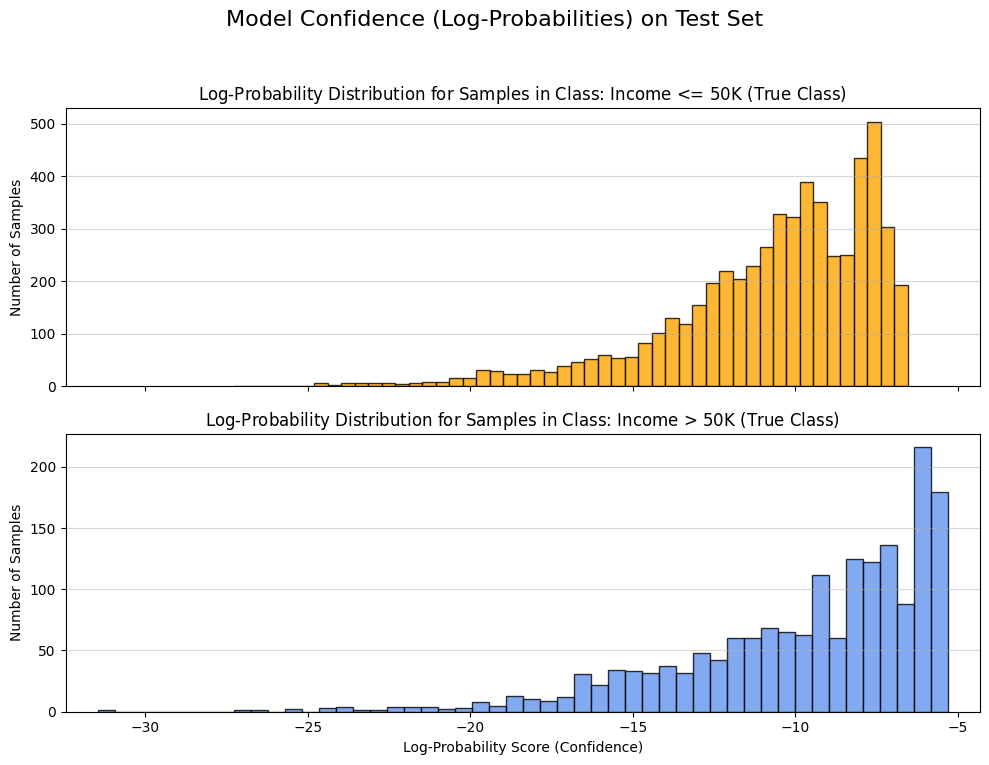

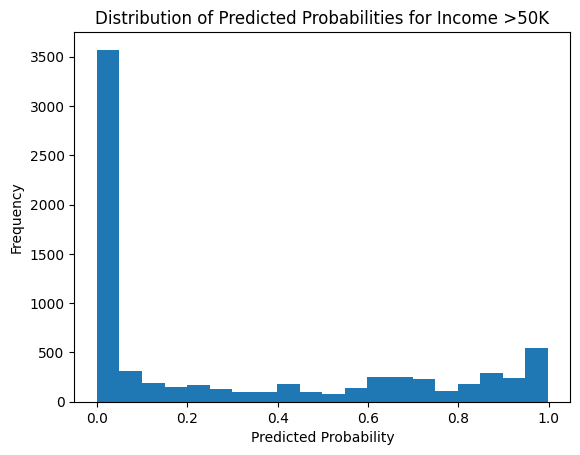

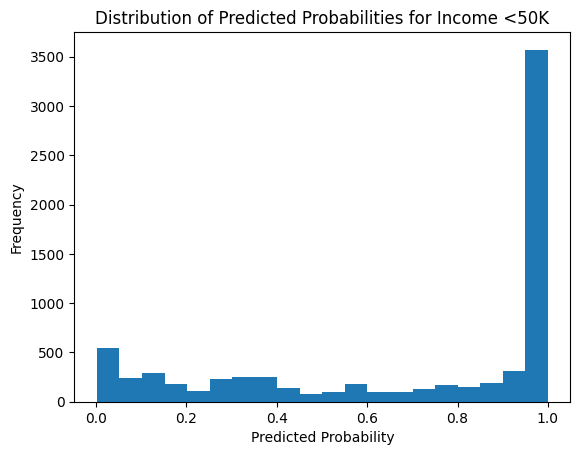

In [36]:

#  Plotting 
def plot_log_probabilities(log_probs, y_true):
    class_labels = {0: 'Income <= $50$K (True Class)', 1: 'Income > $50$K (True Class)'}
    
    log_scores_class_0 = log_probs[y_true == 0, 0] 
    log_scores_class_1 = log_probs[y_true == 1, 1] 

    min_x = min(log_scores_class_0.min(), log_scores_class_1.min()) - 1
    max_x = max(log_scores_class_0.max(), log_scores_class_1.max()) + 1

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    axes[0].hist(log_scores_class_0, bins=50, color='#FFA500', alpha=0.8, edgecolor='black')
    axes[0].set_title(f'Log-Probability Distribution for Samples in Class: {class_labels[0]}')
    axes[0].set_ylabel('Number of Samples')
    axes[0].set_xlim(min_x, max_x)
    axes[0].grid(axis='y', alpha=0.5)
    
    axes[1].hist(log_scores_class_1, bins=50, color='#6495ED', alpha=0.8, edgecolor='black')
    axes[1].set_title(f'Log-Probability Distribution for Samples in Class: {class_labels[1]}')
    axes[1].set_xlabel('Log-Probability Score (Confidence)')
    axes[1].set_ylabel('Number of Samples')
    axes[1].set_xlim(min_x, max_x)
    axes[1].grid(axis='y', alpha=0.5)

    plt.suptitle('Model Confidence (Log-Probabilities) on Test Set', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



if __name__ == "__main__":
    print("Loading Adult dataset...")
    X_df, y = load_adult()
    print("Dataset shape:", X_df.shape)
    cat_cols = get_categorical_columns(X_df)
    print("Categorical columns found:", cat_cols)

    subset_full = cat_cols.copy()
    subset_top3 = [c for c in cat_cols if c in ['education','occupation','workclass']][:3]
    subset_top6 = [c for c in cat_cols if c in ['education','occupation','workclass','marital-status','relationship','sex']]
    subset_minus_occupation = [c for c in subset_full if c != 'occupation']

    manual_subsets = [
        ('Full', subset_full),
        ('Top3', subset_top3),
        ('Top6', subset_top6),
        ('Full_minus_occupation', subset_minus_occupation)
    ]

    results_df = run_manual_subsets(X_df, y, manual_subsets)
    plot_res = run_experiment(X_df, y, feature_subset=subset_full)
    plot_log_probabilities(
            plot_res['log_probs_test'], 
            plot_res['y_test']
        )
    
    class1_probs = plot_res['probs_test'][:, 1]
    plt.hist(class1_probs, bins=20)
    plt.title("Distribution of Predicted Probabilities for Income >50K")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.show()
    class2_probs = plot_res['probs_test'][:, 0]
    plt.hist(class2_probs, bins=20)
    plt.title("Distribution of Predicted Probabilities for Income <50K")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.show()
  

Analysis and Key Findings of Naive Bayes Model PerformanceI.
 Optimal Model Selection and Feature EfficiencyThe experiments comparing different feature subsets clearly indicate that the Custom Categorical Naive Bayes model provides the best performance in classifying adult income, far exceeding the Scikit-learn baseline.The top-performing configurations were the 'Full' subset (using all 8 categorical features) and the 'Top6' subset (excluding 'race' and 'native-country'). Both achieved an Accuracy of approximately 0.7951 and a Macro-averaged F1-score ($\text{F1}_{\text{macro}}$) of 0.7451.Conclusion on Efficiency: The 'Top6' subset (workclass, education, marital-status, occupation, relationship, sex) is the most efficient choice. Since it achieves identical performance to the 'Full' set using fewer features, the 'race' and 'native-country' features were deemed to add negligible predictive value for this model.


II. Feature Importance and Predictive PowerThe study of feature subsets provides critical insights into which variables drive the income prediction:Critical Role of 'Occupation': Removing the 'occupation' feature significantly reduced the model's accuracy, dropping it from $0.7951$ to $0.7717$. This confirms that occupation is a highly critical predictor of an individual's income class.Significance of Social Features: The inclusion of social and relationship features, such as 'marital-status', 'relationship', and 'sex' (which separate the Top3 from the Top6), is highly valuable. The minimal 'Top3' subset yielded a much lower $\text{F1}_{\text{macro}}$ of $0.6726$, demonstrating that these social context variables are essential for achieving robust performance.




For the majority class (income $\le 50$K), the model exhibits very high confidence. The scores are heavily grouped on the right side of the chart, with the main peak clearly falling between $-10$ and $-5$. This strong grouping shows that the model is very sure about its low-income predictions, primarily due to the consistent characteristics found within this majority group.In contrast, 

the minority class (income $> 50$K) shows significantly lower confidence. Its distribution is wider and noticeably shifted toward the left, indicating less certainty in the predictions. The scores for this group peak lower, specifically around $-8$ to $-12$. This suggests the model finds the high-income group harder to predict with high certainty, likely because the minority class is more diverse or its features significantly overlap with the majority group.